CS456 Datamining Final Project
Group 2

The following is an analysis of steam games data provided fom Kaggle.
We will start by importing pandas and numpy. We will also create our main dataframe object.

In [2]:
#Import Statements
import pandas as pd
import numpy as np

#Create Dataframe from CSV
df = pd.read_csv("games.csv", engine="python", on_bad_lines="warn")

#Display first 5 rows and dataframe info
print(df.head(5))
print(df.info())


<ipython-input-2-d626a4d8779d>:6: ParserWarning: Skipping line 43287: unexpected end of data

  df = pd.read_csv("games.csv", engine="python", on_bad_lines="warn")


                         AppID          Name Release date  Estimated owners  \
20200         Galactic Bowling  Oct 21, 2008    0 - 20000                 0   
655370            Train Bandit  Oct 12, 2017    0 - 20000                 0   
1732930           Jolt Project  Nov 17, 2021    0 - 20000                 0   
1355720             Henosisâ¢  Jul 23, 2020    0 - 20000                 0   
1139950  Two Weeks in Painland   Feb 3, 2020    0 - 20000                 0   

         Peak CCU  Required age  Price  DiscountDLC count  \
20200           0         19.99      0                  0   
655370          0          0.99      0                  0   
1732930         0          4.99      0                  0   
1355720         0          5.99      0                  0   
1139950         0          0.00      0                  0   

                                            About the game  \
20200    Galactic Bowling is an exaggerated and stylize...   
655370   THE LAW!! Looks to be a s

We can see here the first 5 rows of the dataframe, and some useful info: datatypes, memory usage, ect. 
Next, we will check for duplicates and missing values:

In [3]:
#Print column names
print("Columns in this dataset:")
print(df.columns)

#Check for duplicates and missing values; start with app IDs if they exist
if "AppID" in df.columns:
    dup_count = df.duplicated(subset="AppID").sum()
    print(f"\nDuplicate AppID rows: {dup_count}")

#If no AppID column, check for fully duplicate rows
else:
    dup_count = df.duplicated().sum()
    print(f"\nDuplicate rows: {dup_count}")

#Show missing values per column 
print("\nTop missing values per column:")

#Make a different dataframe to summarize missing values
missing_summary = df.isna().sum().sort_values(ascending=False)

#Print the missing values dataframe head
print(missing_summary.head(20))


Columns in this dataset:
Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

Duplicate AppID rows: 220

Top missing values per column:
Score rank                  43254
Metacritic url              40637
Notes                       37426
Reviews                     37107
Website                     20924
Support url                 20631
Support email       

We observe that we have alot of columns in this steam games dataset. Our output says we have 1,126 duplicate rows by just appID alone. We made a temporary dataframe to show our top missing values per column. As you can see, ['Score rank'] is at the top of the list. Fortunately however, the following values are never missing in the dataframe: Price, Estimated owners, and Release date.

We will proceed by removing rows with duplicate appIDs from our main dataframe (not the temporary one for missing values):

In [4]:
#Print dataframe shape BEFORE removing duplicate rows
print("Shape before duplicate row removal:", df.shape)

#Drop duplicate rows based on AppID
df.drop_duplicates(subset="AppID", inplace=True)

#Reset the index after dropping duplicate rows
df.reset_index(drop=True, inplace=True)

#Print dataframe shape AFTER removing duplicate rows
print("Shape after duplicate row removal:", df.shape)


Shape before duplicate row removal: (43285, 39)
Shape after duplicate row removal: (43065, 39)


We can see after removing the rows with duplicate AppIDs that we have 110,326 rows and still 39 columns. This means we dropped 1,126 rows that had duplicate AppIDs. When you do the math, this is only about 1% of our total data, but still great for cleaning up! Next we will clean the 'Release Date' column.

In [5]:
#After doing some testing I found that the "Release date" column is incorrectly labeled and actually contains owner range data. Fixed it. 
#Rename the incorrectly-labeled release date column to owner range
df.rename(columns={"Release date": "Owner range"}, inplace=True)
print("Column renamed. 'Release year' removed.")
print(df.columns)


Column renamed. 'Release year' removed.
Index(['AppID', 'Name', 'Owner range', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')


More dataframe cleaning:

In [6]:
#Show missing values before cleaning
print("Missing values BEFORE cleaning:")
print(df.isna().sum().head(20))

#Fill missing numeric columns with 0 or the median
numeric_cols = [
    "Price", 
    "Reviews",
    "Positive", 
    "Negative", 
    "User score",
    "Average playtime forever",
    "Average playtime two weeks",
    "Median playtime forever",
    "Median playtime two weeks"
]

# Loop through numeric columns and fill missing values correctly
for col in numeric_cols:
    if col in df.columns:
        # Convert to numeric so median() won't fail
        df[col] = pd.to_numeric(df[col], errors="coerce")
        
        # Compute median
        median_val = df[col].median()
        
        # If the median is NaN (column entirely NaN), use 0
        if pd.isna(median_val):
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(median_val)

#Fill missing text fields with empty string
text_cols = [
    "Genres", "Tags", "About the game", "Developers",
    "Publishers", "Categories", "Supported languages",
    "Full audio languages"
]

#loop through text columns and fill the missing values
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("")

#Show first 20 columns' missing values after cleaning
print("\nMissing values AFTER cleaning:")
print(df.isna().sum().head(20))


Missing values BEFORE cleaning:
AppID                       1
Name                        0
Owner range                 0
Estimated owners            0
Peak CCU                    0
Required age                0
Price                       0
DiscountDLC count           0
About the game           1111
Supported languages         0
Full audio languages        0
Reviews                 36927
Header image                0
Website                 20820
Support url             20525
Support email            6488
Windows                     0
Mac                         0
Linux                       0
Metacritic score            0
dtype: int64


/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Missing values AFTER cleaning:
AppID                       1
Name                        0
Owner range                 0
Estimated owners            0
Peak CCU                    0
Required age                0
Price                       0
DiscountDLC count           0
About the game              0
Supported languages         0
Full audio languages        0
Reviews                     0
Header image                0
Website                 20820
Support url             20525
Support email            6488
Windows                     0
Mac                         0
Linux                       0
Metacritic score            0
dtype: int64


Alright, this helped us clean up and populate missing stuff. This also helped us confirm some data types, because this data set is kind of messy. Next we'll make some of the genre tags into Python LISTS instead of raw strings for our genres. We'll need it like this for making predictions regarding game genre.

In [7]:
#This was a pain to figure out lol
#Remove brackets and quotes
df["Genres"] = df["Genres"].fillna("").astype(str).str.replace(r"[\[\]']", "", regex=True)
df["Tags"]   = df["Tags"].fillna("").astype(str).str.replace(r"[\[\]']", "", regex=True)

#Split on commas to convert into lists
df["Genres"] = df["Genres"].str.split(",")
df["Tags"]   = df["Tags"].str.split(",")

#Strip whitespace and remove empty strings
df["Genres"] = df["Genres"].apply(lambda lst: [x.strip() for x in lst if x.strip() != ""])
df["Tags"]   = df["Tags"].apply(lambda lst: [x.strip() for x in lst if x.strip() != ""])

#Display first 5 rows of cleaned Genres and Tags columns
df[["Genres", "Tags"]].head(5)

,Genres,Tags
0,"[Casual, Indie, Sports]","[Indie, Casual, Sports, Bowling]"
1,"[Action, Indie]","[Indie, Action, Pixel Graphics, 2D, Retro, Arc..."
2,"[Action, Adventure, Indie, Strategy]",[]
3,"[Adventure, Casual, Indie]","[2D Platformer, Atmospheric, Surreal, Mystery,..."
4,"[Adventure, Indie]","[Indie, Adventure, Nudity, Violent, Sexual Con..."


Our genres and tags columns are now clean and should be good to go to analyze, train models, and make predictions on. The last things to clean are fixing a missing value in AppID and normalize the numeric columns. 

In [8]:
#Import Statements
from sklearn.preprocessing import MinMaxScaler

#Remove rows where AppID is missing
df = df[df["AppID"].notna()]
df.reset_index(drop=True, inplace=True)

print("Rows after dropping missing AppID:", df.shape)

#Normalize numeric columns. Helpful for later on when making predictions
numeric_to_normalize = [
    "Price",
    "Reviews",
    "Positive",
    "Negative",
    "User score",
    "Average playtime forever",
    "Average playtime two weeks",
    "Median playtime forever",
    "Median playtime two weeks"
]

#Keep only numeric columns that actually exist
numeric_to_normalize = [col for col in numeric_to_normalize if col in df.columns]

#Make the scaler object
scaler = MinMaxScaler()

#Normalize the numeric columns so we can make predictions later
df[numeric_to_normalize] = scaler.fit_transform(df[numeric_to_normalize])

#Print first 5 rows of the newly normalized numeric columns
print("Normalization complete.")
print(df[numeric_to_normalize].head())


Rows after dropping missing AppID: (43064, 39)
Normalization complete.
   Price  Reviews  Positive  Negative  User score  Average playtime forever  \
0    0.0      0.0  0.000004  0.000012         0.0                       0.0   
1    0.0      0.0  0.000036  0.000006         0.0                       0.0   
2    0.0      0.0  0.000000  0.000000         0.0                       0.0   
3    0.0      0.0  0.000002  0.000000         0.0                       0.0   
4    0.0      0.0  0.000034  0.000009         0.0                       0.0   

   Average playtime two weeks  Median playtime forever  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0.0                      0.0   

   Median playtime two weeks  
0                        0.0  
1                        0.0  
2           

All of our rows that have numeric values should now be normalized. Any that did not contain values I filled with 0 or the median value. For making predictions later on, I want to make a 'Highly_Rated' and a 'Popular' column. The highly rated column uses the user score column (which is 0 - 1). We will say that anything at or above 80% (or 0.8 in terms of 'user score') will be considered highly rated. Therefore, the highly rated column will be populated with boolean values. The 'Popular' column will work in a similar way, but will only flip to true if the value is greater than the median value in the 'Reviews' column. This data will be useful for any KNN classification:

In [9]:
#Create 'highly_rated'
#The 'User score' column was normalized to 0–1, so 0.8 represents 80/100.
df["highly_rated"] = df["User score"] >= 0.8

#Create 'popular'
#Reviews are also normalized, so we can compare normalized values directly!
median_reviews_norm = df["Reviews"].median()
df["popular"] = df["Reviews"] >= median_reviews_norm

#Show first 10 rows of the new columns
print(df[["User score", "highly_rated", "Reviews", "popular"]].head(10))

   User score  highly_rated  Reviews  popular
0         0.0         False      0.0     True
1         0.0         False      0.0     True
2         0.0         False      0.0     True
3         0.0         False      0.0     True
4         0.0         False      0.0     True
5         0.0         False      0.0     True
6         0.0         False      0.0     True
7         0.0         False      0.0     True
8         0.0         False      0.0     True
9         0.0         False      0.0     True


The logic here is right, but since our dataset doesn't directly come from steam's API we have alot of 0 and NULL values. We will save the cleaned dataframe to a NEW .csv file to deploy what we have learned in CS456 on:

In [10]:
#Save the fully cleaned dataset to a new .csv file
df.to_csv("games_clean.csv", index=False)

#Print to terminal
print("Successfully saved 'games_clean.csv'.")

Successfully saved 'games_clean.csv'.


# Section 1 of 3
## Isaac Darlington

### Question 1: (Statistical) What genre categories have the highest average user playtime? (Average Playtime Forever vs. Average Playtime Last 2 Weeks)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

#Load the dataset
df = pd.read_csv("games_clean.csv", engine="python", on_bad_lines="warn")

#Quick sanity check
print(df.head(3))
print(df.columns)

              AppID          Name Owner range  Estimated owners  Peak CCU  \
0  Galactic Bowling  Oct 21, 2008   0 - 20000                 0         0   
1      Train Bandit  Oct 12, 2017   0 - 20000                 0         0   
2      Jolt Project  Nov 17, 2021   0 - 20000                 0         0   

   Required age  Price  DiscountDLC count  \
0         19.99    0.0                  0   
1          0.99    0.0                  0   
2          4.99    0.0                  0   

                                      About the game  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotics ...   

                                 Supported languages  ...  \
0                                        ['English']  ...   
1  ['English', 'French', 'Italian', 'German', 'Sp...  ...   
2                 ['English', 'Portuguese - Brazil']  ...   

  Median playtime two weeks             

In [3]:
games = df.copy()

#Ensure both playtime columns are numeric
games["Average playtime forever"] = pd.to_numeric(
    games["Average playtime forever"], errors="coerce"
)
games["Average playtime two weeks"] = pd.to_numeric(
    games["Average playtime two weeks"], errors="coerce"
)

#Optionally drop rows where both are missing
games = games.dropna(
    subset=["Average playtime forever", "Average playtime two weeks"],
    how="all"
)

def parse_genres(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except Exception:
        return []

games["Genres_list"] = games["Genres"].apply(parse_genres)
games = games[games["Genres_list"].map(len) > 0]

games_exploded = games.explode("Genres_list").rename(columns={"Genres_list": "Genre"})

In [4]:
genre_stats = (
    games_exploded
    .groupby("Genre")[["Average playtime forever", "Average playtime two weeks"]]
    .mean()
)

#Sort by total playtime (forever) descending
genre_stats = genre_stats.sort_values("Average playtime forever", ascending=False)

#Look at top 10
top_n = 10
genre_stats_top = genre_stats.head(top_n)
print(genre_stats_top)

                       Average playtime forever  Average playtime two weeks
Genre                                                                      
Audio Production                       0.011752                    0.000674
Utilities                              0.007048                    0.003197
Design & Illustration                  0.004723                    0.001050
Web Publishing                         0.004485                    0.001770
Video Production                       0.003379                    0.005048
Massively Multiplayer                  0.002735                    0.005916
Animation & Modeling                   0.002194                    0.000936
Software Training                      0.001758                    0.005419
Photo Editing                          0.001694                    0.000547
Free to Play                           0.001659                    0.002311


In this section I handle the visualization for the question using a bar graph.

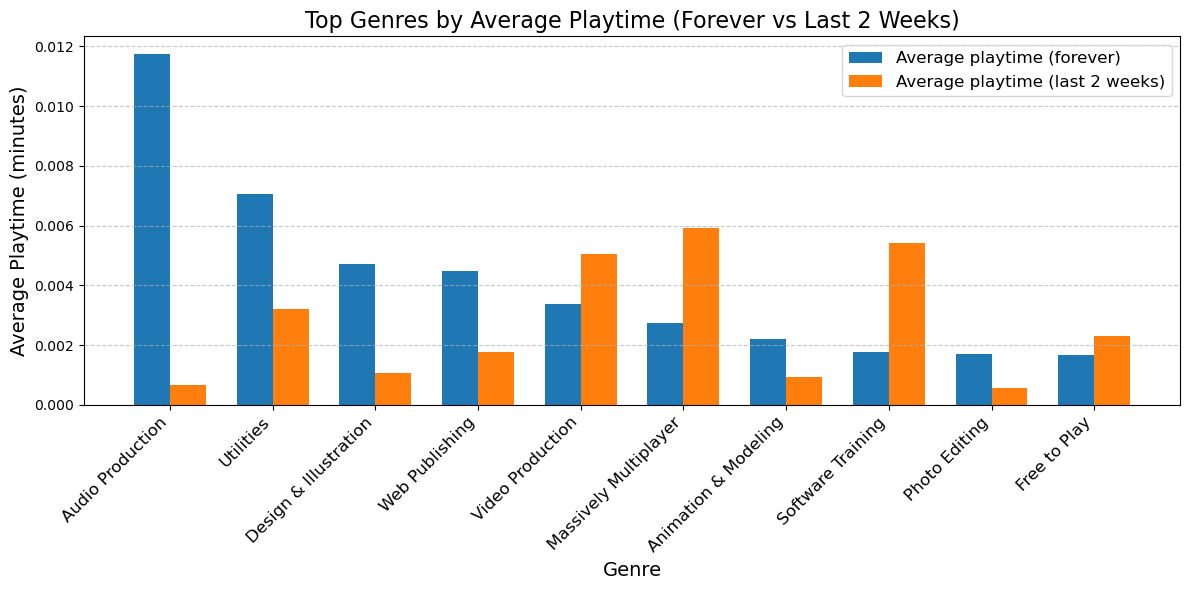

In [5]:
plt.figure(figsize=(12, 6))

x = np.arange(len(genre_stats_top))
width = 0.35                      

#Bars for "forever" playtime
plt.bar(
    x - width/2,
    genre_stats_top["Average playtime forever"],
    width,
    label="Average playtime (forever)"
)

#Bars for "two weeks" playtime
plt.bar(
    x + width/2,
    genre_stats_top["Average playtime two weeks"],
    width,
    label="Average playtime (last 2 weeks)"
)

#X-axis labels (genres)
plt.xticks(x, genre_stats_top.index, rotation=45, ha="right", fontsize=12)

#Titles and labels
plt.title("Top Genres by Average Playtime (Forever vs Last 2 Weeks)", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Average Playtime (minutes)", fontsize=14)

#Grid and legend
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

From what we can see in the results, a lot of the data seems to be massively under even 1 minute of playtime, this can be attributed to a couple factors like the amount of games/software that are in that genre, or potentially the amount of people that use these games/software. Although there is still some semblence of a pattern here, for example Audio Production has the highest average playtime over its entire life time, while the winner for highest average playtime in the last 2 weeks is Massively Multiplayer.


### Question 2: Are there common combinations of genres or tags that frequently appear together?